In [4]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=1000

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [254]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size = 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(18432, 256),
            nn.Dropout(0.1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.decoder_conv = nn.Sequential(
            nn.Linear(256, 18432),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Unflatten(1,(32,24,24)),
            nn.ConvTranspose2d(32, 16, kernel_size = 3),
            #nn.MaxUnpool2d(2,2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size = 3),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.decoder_conv(x)
        return x

In [255]:
loss_fn = torch.nn.MSELoss()
lr= 0.01


torch.manual_seed(0)

encoder = Encoder()
decoder = Decoder()
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_conv): Sequential(
    (0): Linear(in_features=256, out_features=18432, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Unflatten(dim=1, unflattened_size=(32, 24, 24))
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Sigmoid()
  )
)

In [256]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    for image, _ in dataloader:
        img = image.to(device)    
        enc = encoder(img)
        dec = decoder(enc)
        loss = loss_fn(dec, img)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [257]:

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [258]:
def plot_salida(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Imagen original')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Imagen Reconstruida')
    plt.show()


 EPOCH 1/30 	 train loss 0.09911420196294785 	 val loss 0.06713786721229553


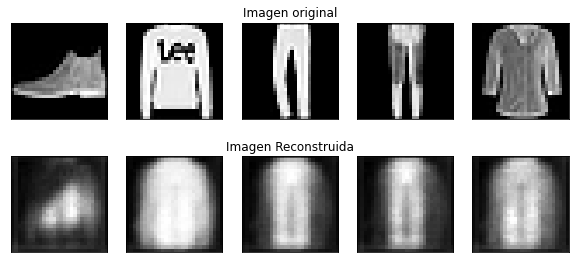


 EPOCH 2/30 	 train loss 0.05343826487660408 	 val loss 0.04140501096844673


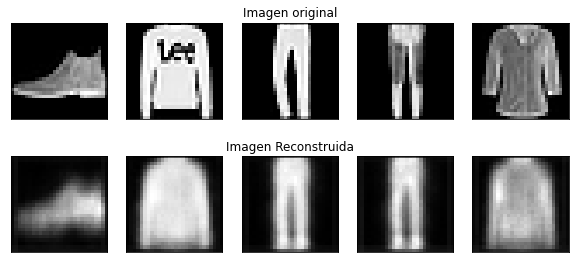


 EPOCH 3/30 	 train loss 0.03682653233408928 	 val loss 0.030469985678792


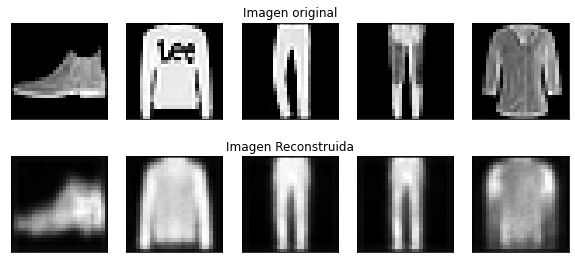


 EPOCH 4/30 	 train loss 0.029260948300361633 	 val loss 0.026648426428437233


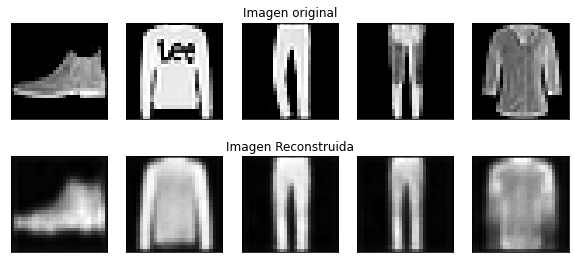


 EPOCH 5/30 	 train loss 0.024931659922003746 	 val loss 0.024018647149205208


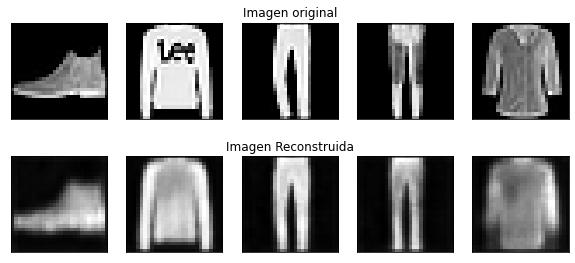


 EPOCH 6/30 	 train loss 0.021480495110154152 	 val loss 0.02170960232615471


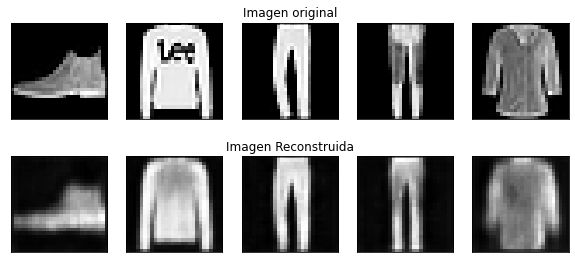


 EPOCH 7/30 	 train loss 0.018604056909680367 	 val loss 0.016768744215369225


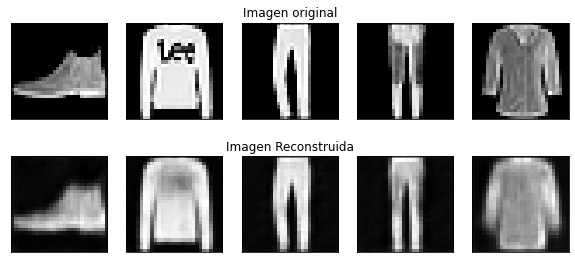


 EPOCH 8/30 	 train loss 0.01626301370561123 	 val loss 0.014346107840538025


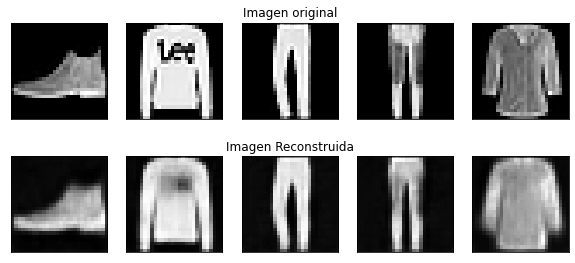


 EPOCH 9/30 	 train loss 0.014515881426632404 	 val loss 0.013165026903152466


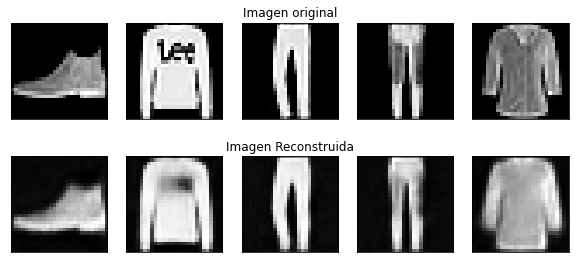


 EPOCH 10/30 	 train loss 0.013163908384740353 	 val loss 0.011799091473221779


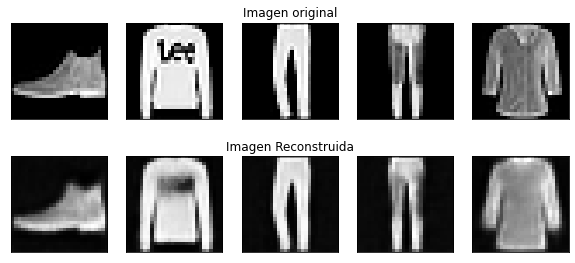


 EPOCH 11/30 	 train loss 0.012156680226325989 	 val loss 0.010189435444772243


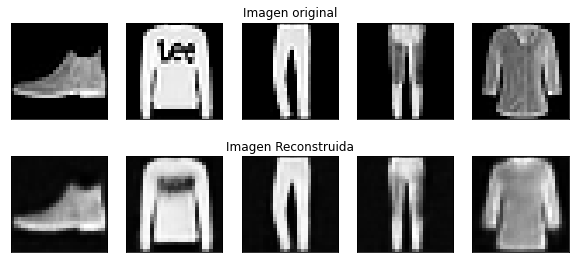


 EPOCH 12/30 	 train loss 0.01138224732130766 	 val loss 0.009462215006351471


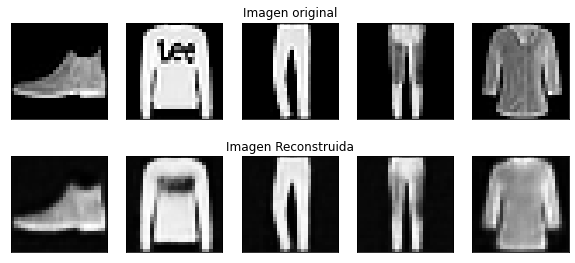


 EPOCH 13/30 	 train loss 0.010744926519691944 	 val loss 0.009040096774697304


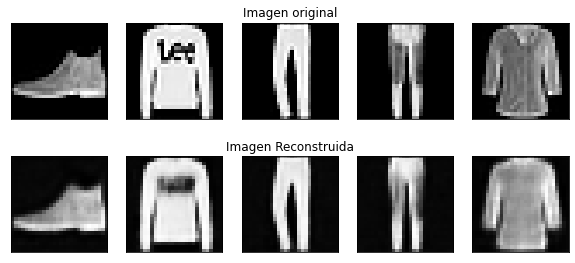


 EPOCH 14/30 	 train loss 0.010243585333228111 	 val loss 0.008669154718518257


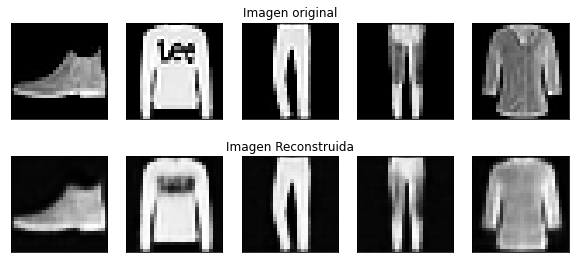


 EPOCH 15/30 	 train loss 0.00984328705817461 	 val loss 0.008173799142241478


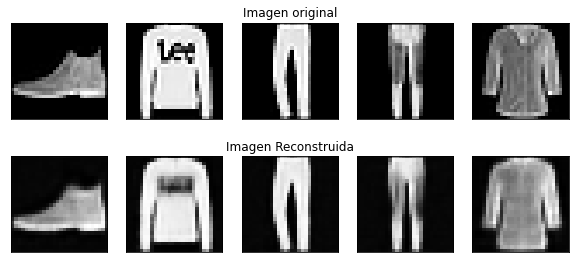


 EPOCH 16/30 	 train loss 0.009502901695668697 	 val loss 0.007876195013523102


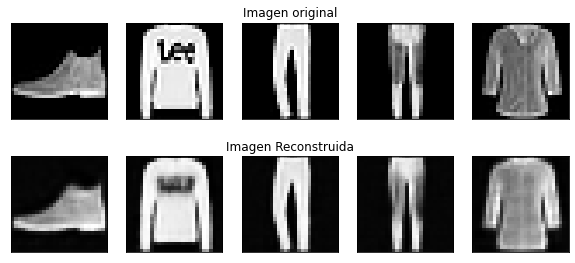


 EPOCH 17/30 	 train loss 0.009186768904328346 	 val loss 0.00782088190317154


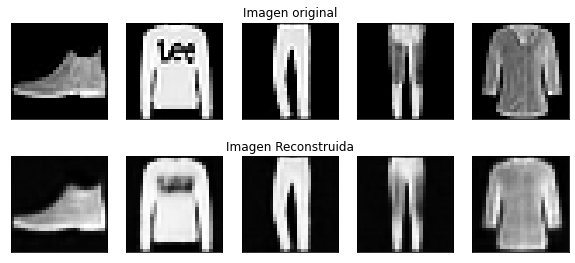


 EPOCH 18/30 	 train loss 0.008948170579969883 	 val loss 0.007477805018424988


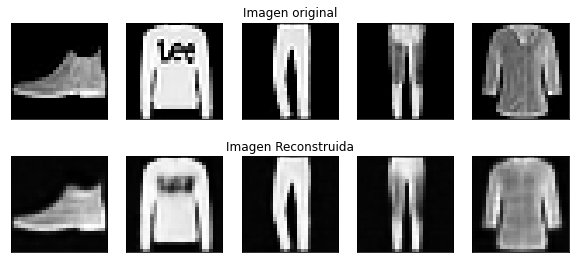


 EPOCH 19/30 	 train loss 0.008722818456590176 	 val loss 0.0073555223643779755


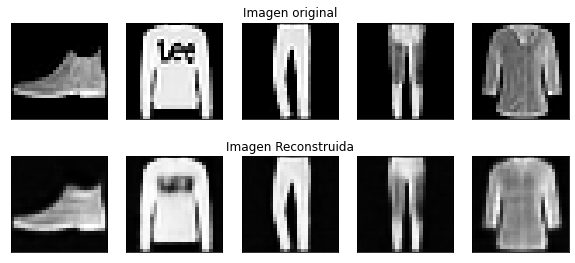


 EPOCH 20/30 	 train loss 0.0085289953276515 	 val loss 0.007120976224541664


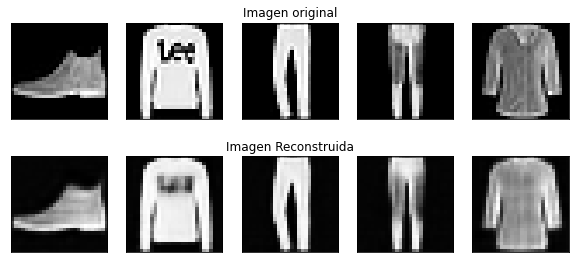


 EPOCH 21/30 	 train loss 0.008364337496459484 	 val loss 0.00689964322373271


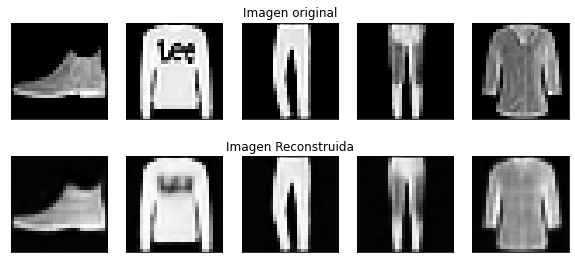


 EPOCH 22/30 	 train loss 0.008219272829592228 	 val loss 0.0067905536852777


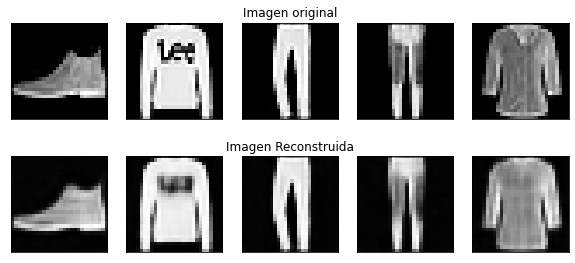


 EPOCH 23/30 	 train loss 0.00806357804685831 	 val loss 0.006556971464306116


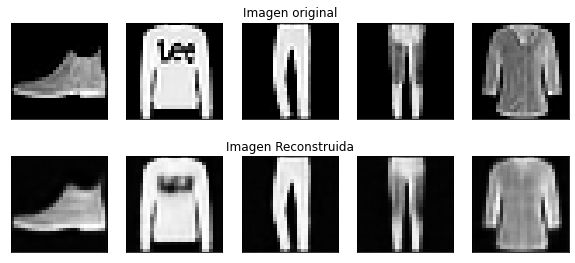


 EPOCH 24/30 	 train loss 0.007918926887214184 	 val loss 0.0065337372943758965


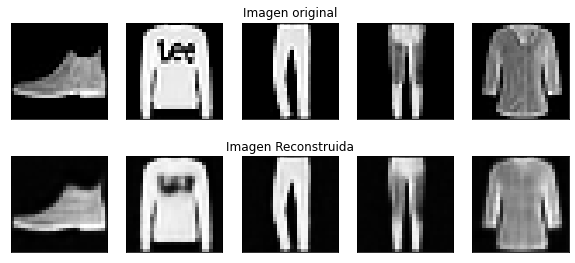


 EPOCH 25/30 	 train loss 0.0077812448143959045 	 val loss 0.006242186296731234


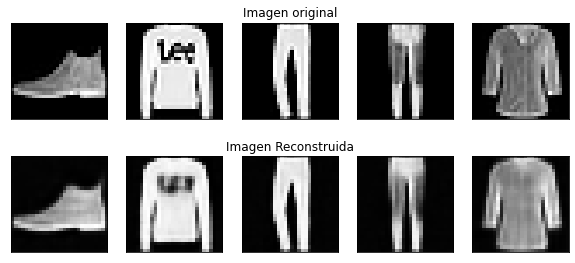


 EPOCH 26/30 	 train loss 0.007658835034817457 	 val loss 0.006257886067032814


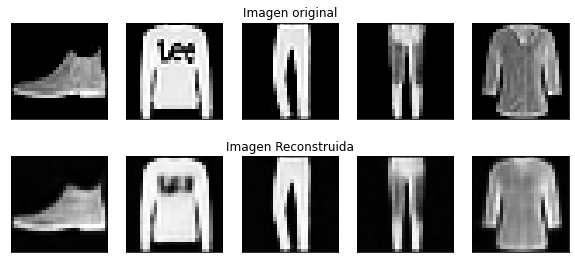


 EPOCH 27/30 	 train loss 0.007557086646556854 	 val loss 0.006138389930129051


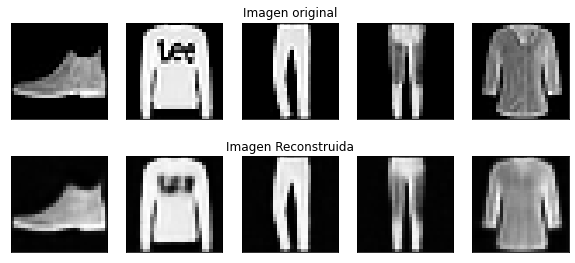


 EPOCH 28/30 	 train loss 0.00747206574305892 	 val loss 0.006158377975225449


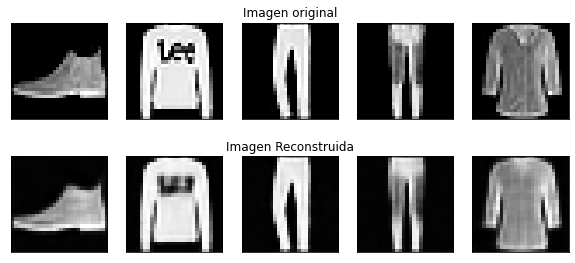


 EPOCH 29/30 	 train loss 0.0073859416879713535 	 val loss 0.005942238494753838


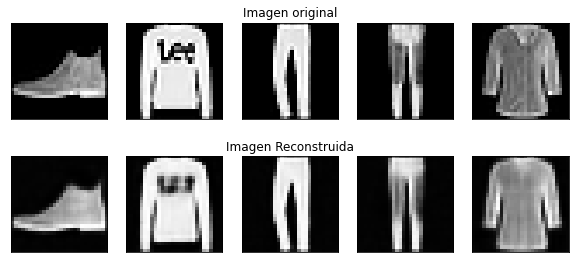


 EPOCH 30/30 	 train loss 0.007328642997890711 	 val loss 0.005974693223834038


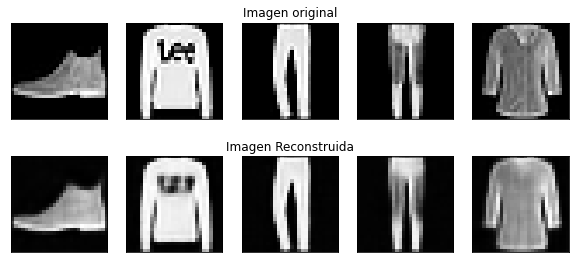

In [259]:
num_epochs = 30
p_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    p_loss['train_loss'].append(train_loss)
    p_loss['val_loss'].append(val_loss)
    plot_salida(encoder,decoder,n=5)

In [261]:
#lr=0.001, MSE, capas intermedias = 128, dropout = 0.1
#lr=0.01 at2
#lr=0.1 at3
#lr=0.0001 at4
at7 = p_loss['train_loss']
bv7 = p_loss['val_loss']

Text(0.5, 1.0, 'Entrenamiento')

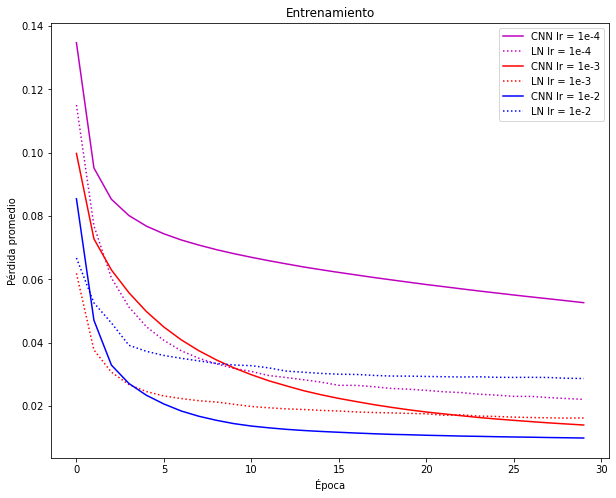

In [136]:
plt.figure(figsize=(10,8))
plt.plot(at_5,'m', label='CNN lr = 1e-4')
plt.plot(c4, 'm:', label='LN lr = 1e-4')
plt.plot(at_3, 'r', label='CNN lr = 1e-3')
plt.plot(c1, 'r:', label='LN lr = 1e-3')
plt.plot(at_1, 'b', label='CNN lr = 1e-2')
plt.plot(c2, 'b:', label='LN lr = 1e-2')
#plt.plot(at_4,'g', label='CNN lr = 1e-1')
#plt.plot(c3, 'g:', label='LN lr = 1e-1')
plt.xlabel('Época')
plt.ylabel('Pérdida promedio')
plt.legend()
plt.title('Entrenamiento')


Text(0.5, 1.0, 'Validación')

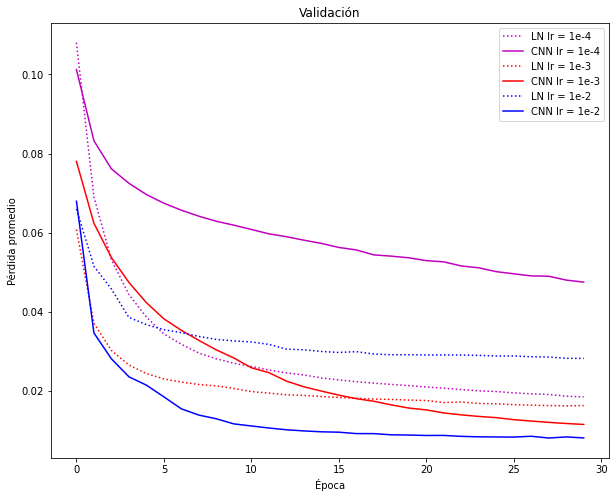

In [135]:
plt.figure(figsize=(10,8))
plt.plot(d4, 'm:', label='LN lr = 1e-4')
plt.plot(bv_5, 'm', label='CNN lr = 1e-4')
plt.plot(d1, 'r:', label='LN lr = 1e-3')
plt.plot(bv_3,'r', label='CNN lr = 1e-3')
plt.plot(d2,'b:', label='LN lr = 1e-2')
plt.plot(bv_1, 'b', label='CNN lr = 1e-2')
#plt.plot(d3,'g:', label='LN lr = 1e-1')
#plt.plot(bv_4,'g', label='CNN lr = 1e-1')
plt.xlabel('Época')
plt.ylabel('Pérdida promedio')
plt.legend()
plt.title('Validación')

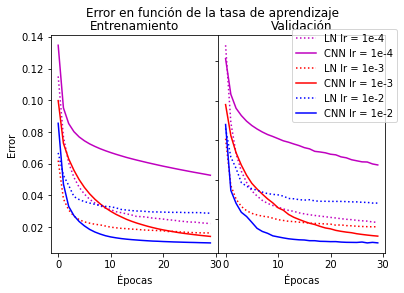

In [231]:
fig1 = plt.figure()
gs = fig1.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col')
ax1.plot(at_5,'m', label='CNN lr = 1e-4')
ax1.plot(c4, 'm:', label='LN lr = 1e-4')
ax1.plot(at_3, 'r', label='CNN lr = 1e-3')
ax1.plot(c1, 'r:', label='LN lr = 1e-3')
ax1.plot(at_1, 'b', label='CNN lr = 1e-2')
ax1.plot(c2, 'b:', label='LN lr = 1e-2')
ax1.set_title("Entrenamiento")
ax1.set(xlabel='Épocas', ylabel='Error')
#ax1.legend()
ax2.plot(d4, 'm:', label='LN lr = 1e-4')
ax2.plot(bv_5, 'm', label='CNN lr = 1e-4')
ax2.plot(d1, 'r:', label='LN lr = 1e-3')
ax2.plot(bv_3,'r', label='CNN lr = 1e-3')
ax2.plot(d2,'b:', label='LN lr = 1e-2')
ax2.plot(bv_1, 'b', label='CNN lr = 1e-2')
ax2.set_title("Validación")
ax2.set(xlabel='Épocas')
ax2.legend(bbox_to_anchor=(1.1, 1.05))
ax2.label_outer()
fig1.suptitle('Error en función de la tasa de aprendizaje')
fig1.savefig('Loss.png')

Text(0.5, 1.0, 'Entrenamiento')

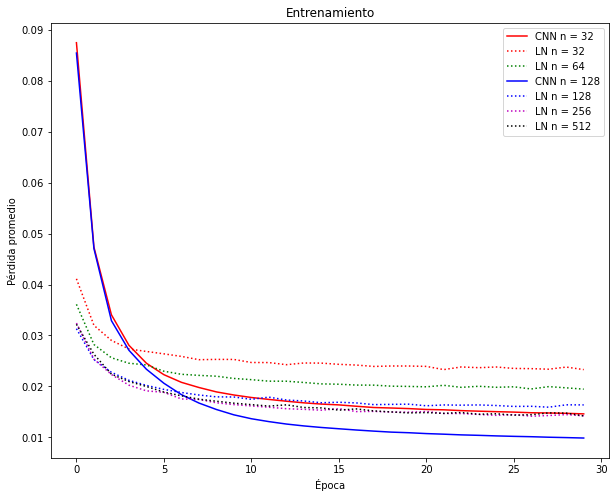

In [240]:
plt.figure(figsize=(10,8))
plt.plot(at6,'r', label='CNN n = 32')
plt.plot(e_1,'r:', label='LN n = 32')
#plt.plot(at5,'g', label='CNN n = 64')
plt.plot(e_2,'g:', label='LN n = 64')
plt.plot(at_1,'b', label='CNN n = 128')
plt.plot(e_3,'b:', label='LN n = 128')
#plt.plot(at7, label='n = 256')
plt.plot(e_4,'m:', label='LN n = 256')
#plt.plot(at8, label='n = 512')
plt.plot(e_5,'k:', label='LN n = 512')
plt.xlabel('Época')
plt.ylabel('Pérdida promedio')
plt.legend()
plt.title('Entrenamiento')


Text(0.5, 1.0, 'Validación')

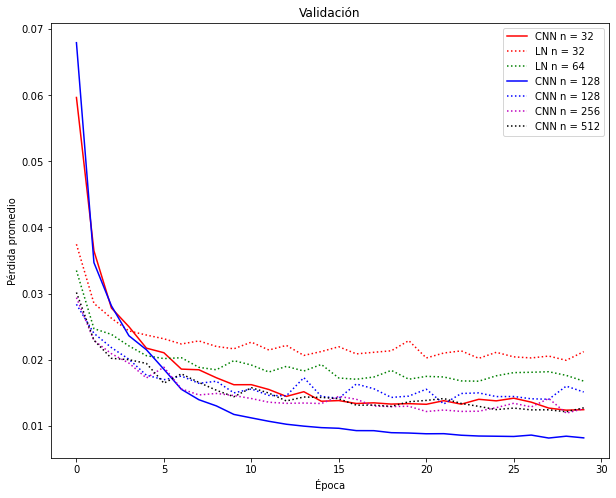

In [241]:
plt.figure(figsize=(10,8))
plt.plot(bv6,'r', label='CNN n = 32')
plt.plot(f_1,'r:', label='LN n = 32')
#plt.plot(bv5,'g', label='CNN n = 64')
plt.plot(f_2,'g:', label='LN n = 64')
plt.plot(bv_1,'b', label='CNN n = 128')
plt.plot(f_3,'b:', label='CNN n = 128')
#plt.plot(bv7, label='CNN n = 256')
plt.plot(f_4,'m:', label='CNN n = 256')
#plt.plot(bv8, label='CNN n = 512')
plt.plot(f_5,'k:', label='CNN n = 512')
plt.xlabel('Época')
plt.ylabel('Pérdida promedio')
plt.legend()
plt.title('Validación')

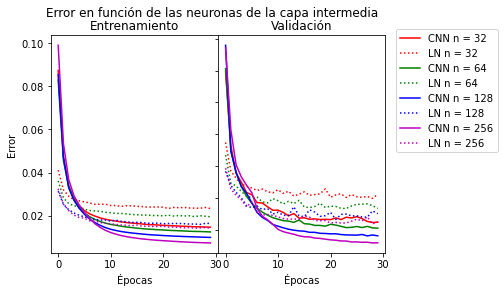

In [262]:
fig1 = plt.figure()
gs = fig1.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col')
ax1.plot(at6,'r', label='CNN n = 32')
ax1.plot(e_1,'r:', label='LN n = 32')
ax1.plot(at5,'g', label='CNN n = 64')
ax1.plot(e_2,'g:', label='LN n = 64')
ax1.plot(at_1,'b', label='CNN n = 128')
ax1.plot(e_3,'b:', label='LN n = 128')
ax1.plot(at7, 'm', label='CNN n = 256')
ax1.plot(e_4,'m:', label='LN n = 256')
#ax1.plot(at8, label='n = 512')
#ax1.plot(e_5,'k:', label='LN n = 512')
ax1.set_title("Entrenamiento")
ax1.set(xlabel='Épocas', ylabel='Error')
#ax1.legend()
ax2.plot(bv6,'r', label='CNN n = 32')
ax2.plot(f_1,'r:', label='LN n = 32')
ax2.plot(bv5,'g', label='CNN n = 64')
ax2.plot(f_2,'g:', label='LN n = 64')
ax2.plot(bv_1,'b', label='CNN n = 128')
ax2.plot(f_3,'b:', label='LN n = 128')
ax2.plot(bv7, 'm', label='CNN n = 256')
ax2.plot(f_4,'m:', label='LN n = 256')
#ax2.plot(bv8, label='CNN n = 512')
#ax2.plot(f_5,'k:', label='CNN n = 512')
ax2.set_title("Validación")
ax2.set(xlabel='Épocas')
ax2.legend(bbox_to_anchor=(1.7, 1.05))
ax2.label_outer()
fig1.suptitle('Error en función de las neuronas de la capa intermedia')
fig1.savefig('Loss1.png')

Text(0.5, 1.0, 'Entrenamiento')

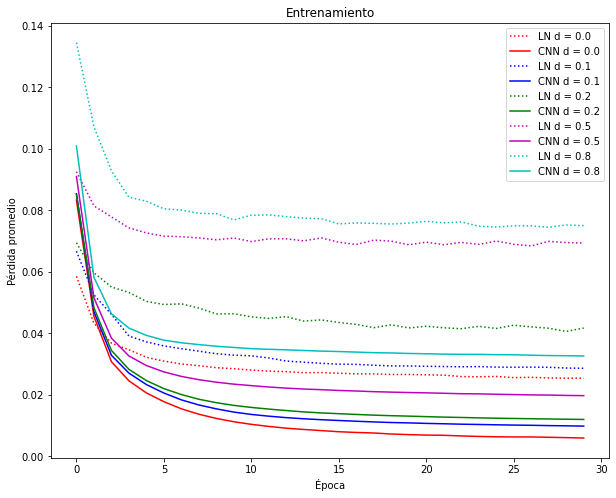

In [172]:
plt.figure(figsize=(10,8))
#plt.plot(at6, label='n = 32')
plt.plot(c8, 'r:', label='LN d = 0.0')
plt.plot(at_2, 'r', label='CNN d = 0.0')
plt.plot(c2, 'b:', label='LN d = 0.1')
plt.plot(at_1, 'b', label='CNN d = 0.1')
plt.plot(c5, 'g:', label='LN d = 0.2')
plt.plot(at1, 'g', label='CNN d = 0.2')
plt.plot(c6, 'm:', label='LN d = 0.5')
plt.plot(at10, 'm', label='CNN d = 0.5')
plt.plot(c7, 'c:', label='LN d = 0.8')
plt.plot(at11, 'c', label='CNN d = 0.8')
plt.xlabel('Época')
plt.ylabel('Pérdida promedio')
plt.legend()
plt.title('Entrenamiento')


Text(0.5, 1.0, 'Validación')

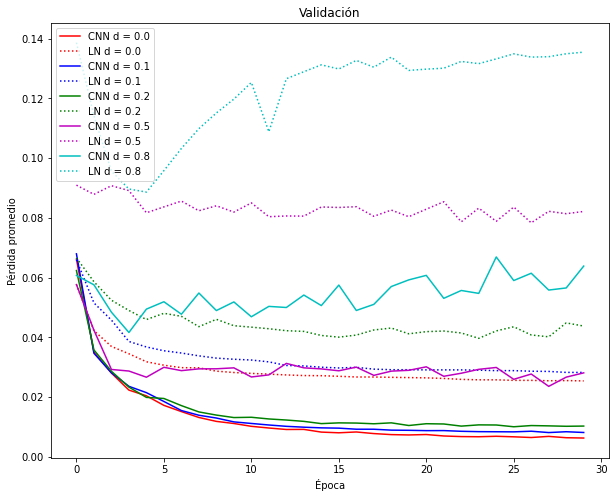

In [173]:
plt.figure(figsize=(10,8))
plt.plot(bv_2, 'r', label='CNN d = 0.0')
plt.plot(d8, 'r:', label='LN d = 0.0')
plt.plot(bv_1, 'b', label='CNN d = 0.1')
plt.plot(d2, 'b:', label='LN d = 0.1')
plt.plot(bv1, 'g', label='CNN d = 0.2')
plt.plot(d5, 'g:', label='LN d = 0.2')
plt.plot(bv10, 'm', label='CNN d = 0.5')
plt.plot(d6, 'm:', label='LN d = 0.5')
plt.plot(bv11, 'c', label='CNN d = 0.8')
plt.plot(d7, 'c:', label='LN d = 0.8')
plt.xlabel('Época')
plt.ylabel('Pérdida promedio')
plt.legend()
plt.title('Validación')

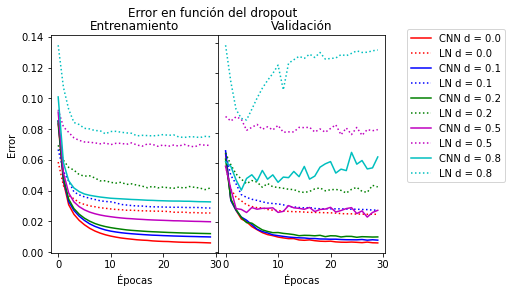

In [230]:
fig1 = plt.figure()
gs = fig1.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col')
ax1.plot(c8, 'r:', label='LN d = 0.0')
ax1.plot(at_2, 'r', label='CNN d = 0.0')
ax1.plot(c2, 'b:', label='LN d = 0.1')
ax1.plot(at_1, 'b', label='CNN d = 0.1')
ax1.plot(c5, 'g:', label='LN d = 0.2')
ax1.plot(at1, 'g', label='CNN d = 0.2')
ax1.plot(c6, 'm:', label='LN d = 0.5')
ax1.plot(at10, 'm', label='CNN d = 0.5')
ax1.plot(c7, 'c:', label='LN d = 0.8')
ax1.plot(at11, 'c', label='CNN d = 0.8')
ax1.set_title("Entrenamiento")
ax1.set(xlabel='Épocas', ylabel='Error')
#ax1.legend()
ax2.plot(bv_2, 'r', label='CNN d = 0.0')
ax2.plot(d8, 'r:', label='LN d = 0.0')
ax2.plot(bv_1, 'b', label='CNN d = 0.1')
ax2.plot(d2, 'b:', label='LN d = 0.1')
ax2.plot(bv1, 'g', label='CNN d = 0.2')
ax2.plot(d5, 'g:', label='LN d = 0.2')
ax2.plot(bv10, 'm', label='CNN d = 0.5')
ax2.plot(d6, 'm:', label='LN d = 0.5')
ax2.plot(bv11, 'c', label='CNN d = 0.8')
ax2.plot(d7, 'c:', label='LN d = 0.8')
ax2.set_title("Validación")
ax2.set(xlabel='Épocas')
ax2.legend(bbox_to_anchor=(1.1, 1.05))
ax2.label_outer()
fig1.suptitle('Error en función del dropout')
fig1.savefig('Loss1.png')

Text(0.5, 1.0, 'Entrenamiento')

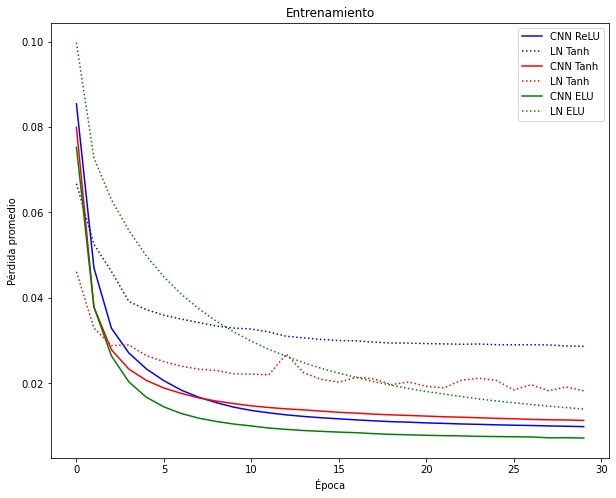

In [191]:
plt.figure(figsize=(10,8))
plt.plot(at_1, 'b', label='CNN ReLU')
plt.plot(c2, 'b:', label='LN Tanh')
plt.plot(at_10, 'r', label='CNN Tanh')
plt.plot(c_1, 'r:', label='LN Tanh')
plt.plot(at_11, 'g', label='CNN ELU')
plt.plot(at_3, 'g:', label='LN ELU')
plt.xlabel('Época')
plt.ylabel('Pérdida promedio')
plt.legend()
plt.title('Entrenamiento')

Text(0.5, 1.0, 'Validación')

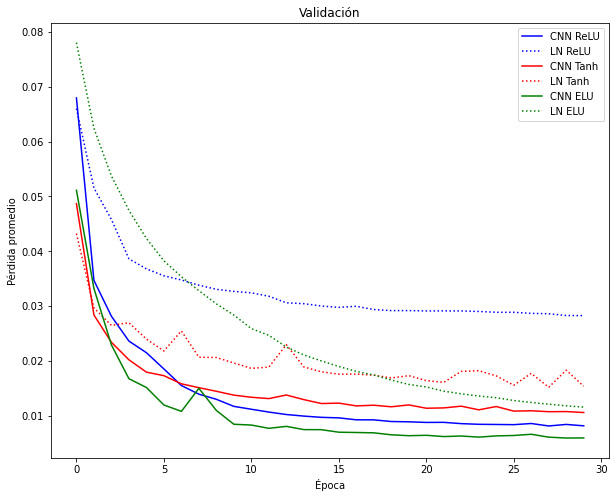

In [192]:
plt.figure(figsize=(10,8))
plt.plot(bv_1, 'b', label='CNN ReLU')
plt.plot(d2, 'b:', label='LN ReLU')
plt.plot(bv_10, 'r', label='CNN Tanh')
plt.plot(d_1, 'r:', label='LN Tanh')
plt.plot(bv_11, 'g', label='CNN ELU')
plt.plot(bv_3, 'g:', label='LN ELU')
plt.xlabel('Época')
plt.ylabel('Pérdida promedio')
plt.legend()
plt.title('Validación')

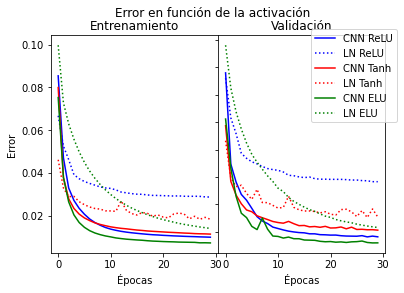

In [232]:
fig1 = plt.figure()
gs = fig1.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col')
ax1.plot(at_1, 'b', label='CNN ReLU')
ax1.plot(c2, 'b:', label='LN Tanh')
ax1.plot(at_10, 'r', label='CNN Tanh')
ax1.plot(c_1, 'r:', label='LN Tanh')
ax1.plot(at_11, 'g', label='CNN ELU')
ax1.plot(at_3, 'g:', label='LN ELU')
ax1.set_title("Entrenamiento")
ax1.set(xlabel='Épocas', ylabel='Error')
#ax1.legend()
ax2.plot(bv_1, 'b', label='CNN ReLU')
ax2.plot(d2, 'b:', label='LN ReLU')
ax2.plot(bv_10, 'r', label='CNN Tanh')
ax2.plot(d_1, 'r:', label='LN Tanh')
ax2.plot(bv_11, 'g', label='CNN ELU')
ax2.plot(bv_3, 'g:', label='LN ELU')
ax2.set_title("Validación")
ax2.set(xlabel='Épocas')
ax2.legend(bbox_to_anchor=(1.1, 1.05))
ax2.label_outer()
fig1.suptitle('Error en función de la activación')
fig1.savefig('Loss2.png')

In [99]:
# import packages
import os
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sklearn as skl
import pandas as pd
import numpy as np
from torch.autograd import Variable
from collections import defaultdict
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
from matplotlib.pyplot import cm
import datetime
import pickle
import dill
import json

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [101]:
class CustomImageDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,i):
        image, label = self.dataset[i]
        label = torch.flatten(image)
        return image, label

In [102]:
train_dataset = CustomImageDataset(train_dataset)
test_dataset = CustomImageDataset(test_dataset)

In [194]:
class Autoencoder(nn.Module):
    def __init__(self, n=64, p=0.1):
        super(Autoencoder,self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, n),  # reduces from n * 724 to 128
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(n, n),
            nn.ReLU())

        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(n, n),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(n, 28 * 28),
            nn.Sigmoid())

    #feed data through network
    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [185]:
model = Autoencoder().to(device)

In [186]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose_each = 20, verbose = False):
    num_samples = len(dataloader.dataset)
    model.train()
    model = model.to(device)
    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and batch % verbose_each*len(X) == 0:
            loss = loss.item()
            sample = batch*len(X)
            print(f"batch={batch} loss={loss:>7f} muestras: {sample:>5d}/{num_samples:>5d}")
    return loss

In [187]:
def test_loop(dataloader, model, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    avg_loss = 0
    frac_correct = 0
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            #pred = torch.max(pred, 1)[0].to(device)
            avg_loss += loss_fn(pred, y).item()
            #frac_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    avg_loss /= num_batches
    #frac_correct /= num_samples
    return avg_loss

In [220]:
lre = 0.01
batch_size = 1000
num_epochs = 30
n = 512

loss_fn = nn.MSELoss()
df = pd.DataFrame()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

model = Autoencoder(n)
optimizer = torch.optim.Adam(model.parameters(), lr = lre)
#optimizer = torch.optim.SGD(model.parameters(), lr = lre)

In [221]:
loss_train = []
loss_train2 = []
loss_test = []
epochs_total = []
for epoch in range(num_epochs):
    loss = train_loop(train_dataloader, model, loss_fn, optimizer, verbose_each = 20)
    train_loss = test_loop(train_dataloader, model, loss_fn)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    loss_train.append(loss)
    loss_train2.append(train_loss)
    loss_test.append(test_loss)
    epochs_total.append(epoch+1)
    #print(f"epoch={epoch} loss={loss}")
    print(f"epoch={epoch} train_loss={train_loss} test_loss={test_loss}")

epoch=0 train_loss=0.030279351832966008 test_loss=0.030170444399118423
epoch=1 train_loss=0.022883303184062242 test_loss=0.022956381924450396
epoch=2 train_loss=0.02014650609344244 test_loss=0.020203630439937115
epoch=3 train_loss=0.01990676773712039 test_loss=0.020000850409269334
epoch=4 train_loss=0.019305733684450387 test_loss=0.019431830011308195
epoch=5 train_loss=0.016299064457416534 test_loss=0.01644411701709032
epoch=6 train_loss=0.017715937457978725 test_loss=0.01785591747611761
epoch=7 train_loss=0.016397363940874734 test_loss=0.016561903432011603
epoch=8 train_loss=0.015202379506081342 test_loss=0.015375507343560458
epoch=9 train_loss=0.01419315232584874 test_loss=0.01439173324033618
epoch=10 train_loss=0.015571049600839614 test_loss=0.015758230909705163
epoch=11 train_loss=0.01473205715107421 test_loss=0.01494719497859478
epoch=12 train_loss=0.013547315200169881 test_loss=0.013759302534162998
epoch=13 train_loss=0.014143479817236463 test_loss=0.014355522952973843
epoch=14 t

In [222]:
e_5 = loss_train
f_5 = loss_test